# Challenge: OpenQAOA

Quantum computing is used extensively for modelling and solving combinatorial optimisation problems. The purpose of this is to find a problem with binary clauses where the amount of states is immense and difficult to solve with classical resources. This type of problem is known as NP-hard. in order to uncover the correct answers, quantum computing produces algorithms of NP-complexity. On the other hand, in quantum computing, we are interested in representing such a model in a quantum circuit and being able to find the optimal states that satisfy the cost function using a classical optimizer.

Multiple companies work around computers and generate an SDK that can generate quantum circuits, in this challenge, we focus on a fundamental step of the Quantum Approximate Optimization Algorithm (QAOA) algorithm. Before starting the quantum part, one must model a problem in terms of 0 and 1 and convert it into a Quadratic unconstrained binary optimization (QUBO) form that can then be converted into an Ising model to find the optimal states. To validate the model one makes use of OpenQAOA, an SDK focused on circuitry of the QAOA algorithm. 

If you want to know more about this SDK you can check the following link https://openqaoa.entropicalabs.com/ 

**NOTES**: 
>
>   * To run on real QPU or  simulators you can use  [qbraid](https://account.qbraid.com/) 
>
>   * The [OpenQAOA workflow](https://openqaoa.entropicalabs.com/workflows/customise-the-QAOA-workflow/#the-circuit-properties)
>
>   * To guide you, you can check out [examples of problems in OpenQAOA](https://github.com/entropicalabs/openqaoa/tree/main/examples/community_tutorials)

# Problem to solve

Find a real-world problem that can benefit from the application of combinatorial optimization. Consult the list of [OpenQAOA](https://openqaoa.entropicalabs.com/) problem classes to find references. 

Your solution's innovativeness will be rewarded with extra points.

The process is the following

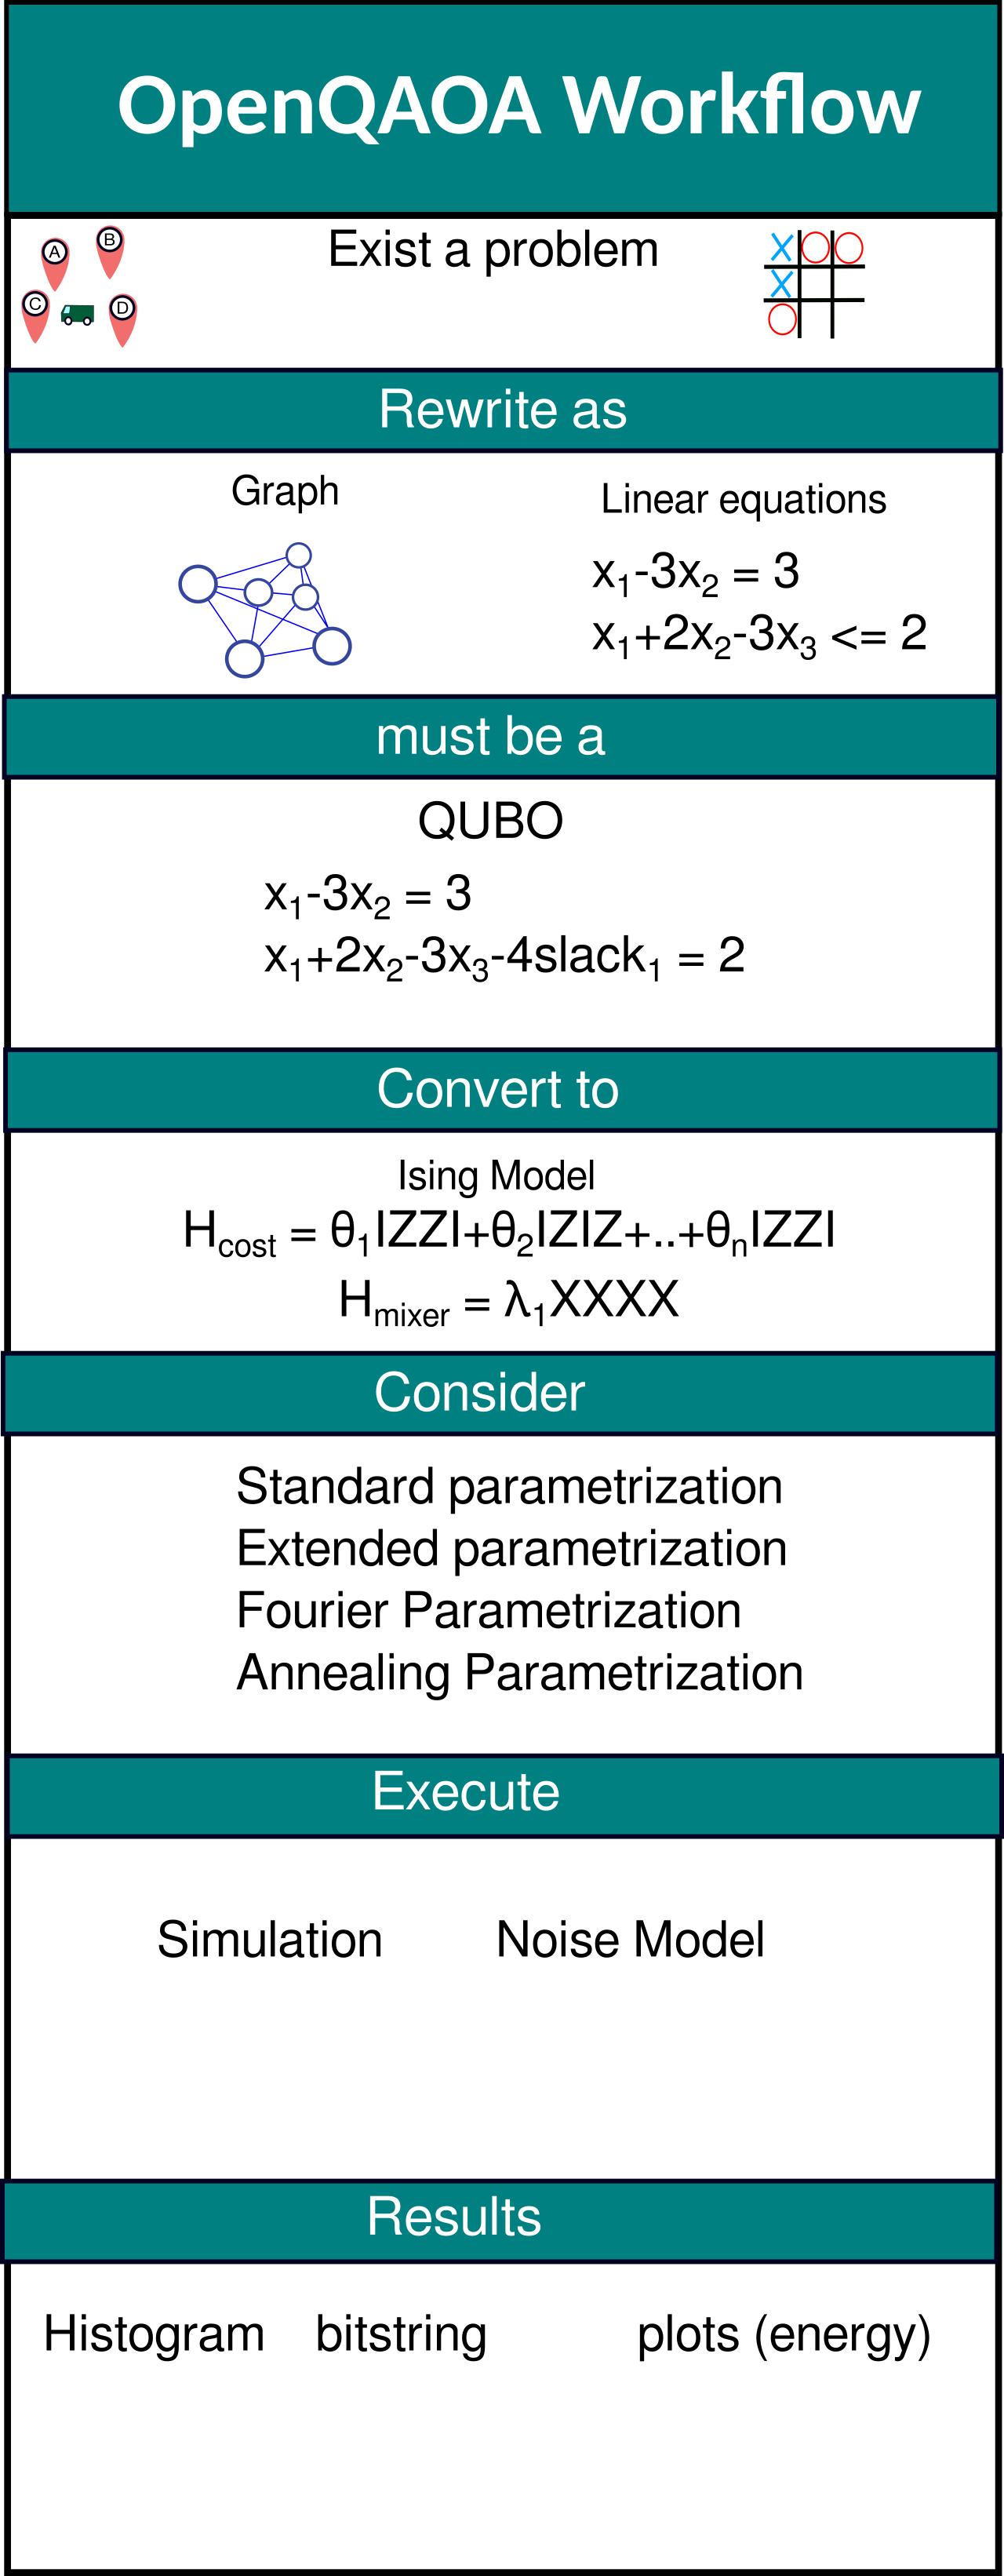

## Part 1: Define your problem and solve it using QAOA
Considering the examples based on OpenQAOA, we already have different classes and methods that facilitate the construction of quantum circuits, but to generate a QUBO we will rely on docplex.

You can find more information on QAOA [examples](https://github.com/entropicalabs/openqaoa/tree/main/examples) and how to generate [QUBOs](https://openqaoa.entropicalabs.com/problems/what-is-a-qubo/) in the [OpenQAOA documentation](https://openqaoa.entropicalabs.com/). The code is available on [GitHub](https://github.com/entropicalabs/openqaoa/tree/main) and you can find more details of implementation in the [API reference](https://el-openqaoa.readthedocs.io/en/main/index.html).

In [1]:
%matplotlib notebook

# Import external libraries to present an manipulate the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import docplex model to generate the problem to optimize
from docplex.mp.model import Model

# Import the libraries needed to employ the QAOA quantum algorithm using OpenQAOA
from openqaoa import QAOA

# method to covnert a docplex model to a qubo problem
from openqaoa.problems.converters import FromDocplex2IsingModel #check this method and properties
from openqaoa.backends import create_device

# method to find the correct states for the QAOA object 
from openqaoa.utilities import ground_state_hamiltonian

We will do simple verion of [the Task Scheduling Problem (TSP)](https://parasollab.web.illinois.edu/research/scheduling/#:~:text=The%20task%20scheduling%20problem%20is,directed%20acyclic%20graph%20(DAG).) for the challenge. This a fundamental challenge in combinatorial optimization, where the goal is to allocate a set of tasks to specific time slots such that the overall schedule maximizes certain objectives—such as total task priority. It is a complex combinatorial optimization problem as the number of potential schedules increases exponentially with the addition of tasks, making traditional enumeration approaches computationally infeasible for large sets of tasks.

In the context of our TSP, binary variables will be employed to represent the inclusion or exclusion of tasks in the schedule. The Quantum Approximate Optimization Algorithm (QAOA) will be utilized to efficiently navigate the search space. The objective function in our TSP is to maximize the aggregated priority of the selected tasks within the constraints of the maximum allowable total task duration.

<div class="alert alert-block alert-danger">
    
*Note*: For our problem, we are considering that tasks cannot be done in parallel, i.e., in a time slot the tasks are done one after the other.
</div>

Code your problem

In [2]:
# Inputs:
tasks = [0, 1, 2] # List of tasks, each task is identified by a unique number (0, 1, 2).
time_slot = [0] # List containing a single time slot (0) for simplicity in this example.
priorities = [3, 2, 1] # List of priorities for each task, where a higher number indicates a higher priority. Corresponds to `weights`.
durations = [2, 1, 3] # List of durations for each task, indicating how long each task takes to complete.
max_duration = 5 # The maximum total duration allowed for all tasks within the time slot. Corresponds to `max_weight`.

def TaskSchedulingProblem(tasks, time_slot, priorities, durations, max_duration):
    # Create an optimization model named 'task_scheduling'/Initialize a model:
    mdl = Model('task_scheduling')

    # Create a binary variable for each task in a dictionary/Indicate the binary variables.
    x = {t: mdl.binary_var(name=f'x_{t}') for t in tasks} # If a variable is 1, the task is scheduled; if 0, it is not.

    # Define the objective function to maximize the sum of the priorities of the scheduled tasks.
    mdl.maximize(mdl.sum(priorities[t] * x[t] for t in tasks)) # It calculates a weighted sum where each task's binary variable is weighted by its priority.
    
    # Constraint for the total duration of the scheduled tasks.
    # Instead of using an inequality constraint, we can ensure that the sum of durations [...]
    # [...] multiplied by the binary decision variable is exactly equal to the maximum duration.
    # This removes the need for slack variables:
    total_duration_expr = mdl.sum(durations[t] * x[t] for t in tasks)
    mdl.add_constraint(total_duration_expr == max_duration, "max_duration_constraint")
    
    # Return model.
    return mdl # Check with FromDocplex2IsingModel.

In [3]:
# Create the model:
problem = TaskSchedulingProblem(tasks, time_slot, priorities, durations, max_duration)

print(problem.prettyprint())

// This file has been generated by DOcplex
// model name is: task_scheduling
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;

maximize
 3 x_0 + 2 x_1 + x_2;
 
subject to {
 max_duration_constraint:
  2 x_0 + x_1 + 3 x_2 == 5;

}
None


In [4]:
# Ising encoding of the QUBO problem for binpacking problem
qubo_converter = FromDocplex2IsingModel(problem)

# Docplex encoding of the QUBO problem for binpacking problem
qubo_docplex, ising_model = qubo_converter.get_models()

qubo_docplex.prettyprint()

// This file has been generated by DOcplex
// model name is: task_scheduling
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;

minimize
 - 143 x_0 - 72 x_1 - 211 x_2 [ 28 x_0^2 + 28 x_0*x_1 + 84 x_0*x_2 + 7 x_1^2
 + 42 x_1*x_2 + 63 x_2^2 ] + 175;
 
subject to {

}


In this first part, we can notice the transition from a classical optimization model in DOcplex to a quantum Ising model is particularly. Although the constraint does not appear explicitly in the QUBO representation, this could be due to the nature of the problem. We will see during the process if the constraint is being accounted for.

In [5]:
# Initialize the QAOA object
qaoa = QAOA()

# Set the parameters to use the QAOA algorithm
# where n_shots=1024 and  seed_simulator=1
qaoa.set_backend_properties(n_shots=1024, seed_simulator=1)

# p=1, a custom type and range from 0 to pi

qaoa.compile(ising_model)

# Run the QAOA algorithm
qaoa.optimize()

pd.DataFrame(qaoa.result.lowest_cost_bitstrings(8))

solutions_bitstrings  bitstrings_energies  probabilities
0                  101                 -4.0       0.184803
1                  111                  1.0       0.212477
2                  011                  4.0       0.320020
3                  110                 23.0       0.047347
4                  001                 27.0       0.044277
5                  100                 60.0       0.056918
6                  010                110.0       0.129274
7                  000                175.0       0.004884

In [6]:
# To find the correct answer using ground_state_hamiltonian
# and the parameter is a cost_hamiltonian
correct_solution = ground_state_hamiltonian(qaoa.cost_hamil)
correct_solution

(-4.0, ['101'])

Validate your answer using docplex, you can see how to check the classical solution using the following tutorial [here](https://github.com/entropicalabs/openqaoa/blob/main/examples/community_tutorials/02_docplex_example.ipynb) 

In [7]:
## docplex solution
sol = qubo_docplex.solve()
qubo_docplex.print_solution(print_zeros=True)

objective: -4.000
status: OPTIMAL_SOLUTION(2)
  x_0=1
  x_1=0
  x_2=1


<div class="alert alert-block alert-warning">
    
The results presented here align logically with the input parameters of the TSP and demonstrate for a simple example, how to apply quantum computing for combinatorial optimization. The output bitstring '101' suggests that tasks 0 and 2 are to be included in the schedule, while task 1 is excluded. *This decision is based on the priorities and durations of the tasks*: task 0 has a high priority (3) with a duration of 2, and task 2 has the lowest priority (1) but also the longest duration (3). When scheduled together, tasks 0 and 2 fulfill the maximum duration constraint exactly, which is 5 time units in total.

    
The negative energy value (-4.0) in the quantum result indicates an optimal solution with respect to the objective function, which is to maximize the total priority of the scheduled tasks. This corresponds to the classical solution found by the DOcplex model, and follows the constraint.

    
Nevertheless, the quantum algorithm does not necessarily eliminate all invalid solutions from the search space.

    
In terms of quantum computing skills, the project showcases the capability to model classical problems for quantum solutions, the conversion of these models into a format suitable for quantum computation, and the utilization of a quantum algorithm (QAOA) to find an optimal solution.
</div>

## Part 2: Improve the QAOA circuit

Perform the same process as above now with the variant of using different backends, p values, and different optimizers until you find the one that can provide the correct answers with the least number of iterations, quantum circuit depth.

In [8]:
## Implementation

# Initialize the QAOA object and use a device:
device = create_device("local", 'qiskit.qasm_simulator')

qaoa = QAOA(device)

# Set the parameters to work the QAOA algorithm
# play with the parameters values

#Indicate the properties to the QAOA quantum algorithm,shots,seed:
qaoa.set_backend_properties(n_shots=1024, seed_simulator=1)
#check the p value and the variational init params:
qaoa.set_circuit_properties(p=2, init_type="custom", variational_params_dict={"betas":2*[0.01*np.pi],"gammas":2*[0.01*np.pi]})

# Compile the QAOA with the Ising model of the task scheduling problem:
qaoa.compile(ising_model)

# Run the QAOA algorithm
qaoa.optimize()

pd.DataFrame(qaoa.result.lowest_cost_bitstrings(8))

solutions_bitstrings  bitstrings_energies  probabilities
0                  101                 -4.0       0.035156
1                  111                  1.0       0.063477
2                  011                  4.0       0.022461
3                  110                 23.0       0.363281
4                  001                 27.0       0.480469
5                  100                 60.0       0.016602
6                  010                110.0       0.012695
7                  000                175.0       0.005859

### Extra: Compare Qiskit Simulators with different simulation methods

As part of the Hackathon test, let's use different simulator backends to solve the same problem and compare their simulation results.

In [9]:
# Others:

device_sv = create_device("local", 'qiskit.statevector_simulator')

qaoa_sv = QAOA(device_sv)

qaoa_sv.set_backend_properties(n_shots=1024, seed_simulator=1)

# Playing with the parameters values.
# Circuit properties/Check the p value and the variational init params:
qaoa_sv.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# Classical optimizer properties:
qaoa_sv.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                             cost_progress=True, parameter_log=True)

# Compile the QAOA with the Ising model of the task scheduling problem:
qaoa_sv.compile(ising_model)

# Run the QAOA algorithm
qaoa_sv.optimize()

pd.DataFrame(qaoa_sv.result.lowest_cost_bitstrings(8))

solutions_bitstrings  bitstrings_energies  probabilities
0                  101                 -4.0       0.209425
1                  111                  1.0       0.049032
2                  011                  4.0       0.612317
3                  110                 23.0       0.000609
4                  001                 27.0       0.065913
5                  100                 60.0       0.022718
6                  010                110.0       0.037558
7                  000                175.0       0.002430

In [10]:
device_shot = create_device("local", 'qiskit.qasm_simulator')

qaoa_shot = QAOA(device_shot)

qaoa_shot.set_backend_properties(n_shots=1024, seed_simulator=1)

# Circuit properties:
qaoa_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# classical optimizer properties
qaoa_shot.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                               cost_progress=True, parameter_log=True)

# Compile the QAOA with the Ising model of the task scheduling problem:
qaoa_shot.compile(ising_model)

# Run the QAOA algorithm
qaoa_shot.optimize()

pd.DataFrame(qaoa_shot.result.lowest_cost_bitstrings(8))

solutions_bitstrings  bitstrings_energies  probabilities
0                  101                 -4.0       0.542969
1                  111                  1.0       0.004883
2                  011                  4.0       0.026367
3                  110                 23.0       0.042969
4                  001                 27.0       0.345703
5                  100                 60.0       0.013672
6                  010                110.0       0.021484
7                  000                175.0       0.001953

<div class="alert alert-block alert-info">

    
We are comparing the results from the QAOA algorithm with different backends and parameter configurations.

    
In all cases, the bitstring `101` is identified as the solution with the lowest energy, which is the optimal answer given the problem constraints. This consistency across different backends and parameter settings indicates that the QAOA algorithm works well for this particular problem.

    
But also, the probability associated with the optimal solution `101` has decreased in some case using the Qiskit backend. While the solutions and their energies are an important part of the result, other metrics like the number of iterations required to converge to the solution and the depth of the quantum circuit are also crucial.

    
Still, for the `qiskit.qasm_simulator` with the classical optimizer we got the best result so far. The mixer Hamiltonian we used determines how the algorithm explores the solution space. An 'X' mixer (applying Pauli-X gates) is an standard choice for QAOA and promotes exploration by flipping the qubits from 0 to 1 and vice versa. The high probability of '101' suggests that these settings allowed the QAOA to effectively navigate the solution space and concentrate the quantum state around the optimal solution.

    
Regarding the use of Qiskit as a backend, the results indicate that changing backends and variational parameters can significantly impact the distribution of probabilities for each solution. This illustrates the importance of backend selection and parameter tuning in quantum algorithm performance.
</div>

## Part 3: Noise Model

The optimal combination that you found with the best optimizer, the lowest number of $p$'s and the correct answer, can give the same answer with noise, use the circuit with a noise model and identify if it gives the same answer.

In [11]:
# implementation using a noise model using qiskit 

## real hardware
from qiskit.providers.fake_provider import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
device_backend = FakeVigo()
device2 = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device2)

# initialize the QAOA object
q = QAOA()

device_noisy = create_device("local", 'qiskit.qasm_simulator')
# choose the noise model

# set your device
q.set_device(device_noisy)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# Backend properties with noise:
q.set_backend_properties(n_shots = 200, noise_model = noise_model)

# set the parameters to work the QAOA algorithm
q.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                                     cost_progress=True, parameter_log=True)

q.compile(ising_model)

# run the QAOA algorithm
q.optimize()

pd.DataFrame(q.result.lowest_cost_bitstrings(8))

solutions_bitstrings  bitstrings_energies  probabilities
0                  101                 -4.0          0.110
1                  111                  1.0          0.270
2                  011                  4.0          0.265
3                  110                 23.0          0.260
4                  001                 27.0          0.045
5                  100                 60.0          0.025
6                  010                110.0          0.010
7                  000                175.0          0.015

# Plots:

In [12]:
results_sv = qaoa_sv.result
results_shot = qaoa_shot.result
results_noisy_shot = q.result

<IPython.core.display.Javascript object>


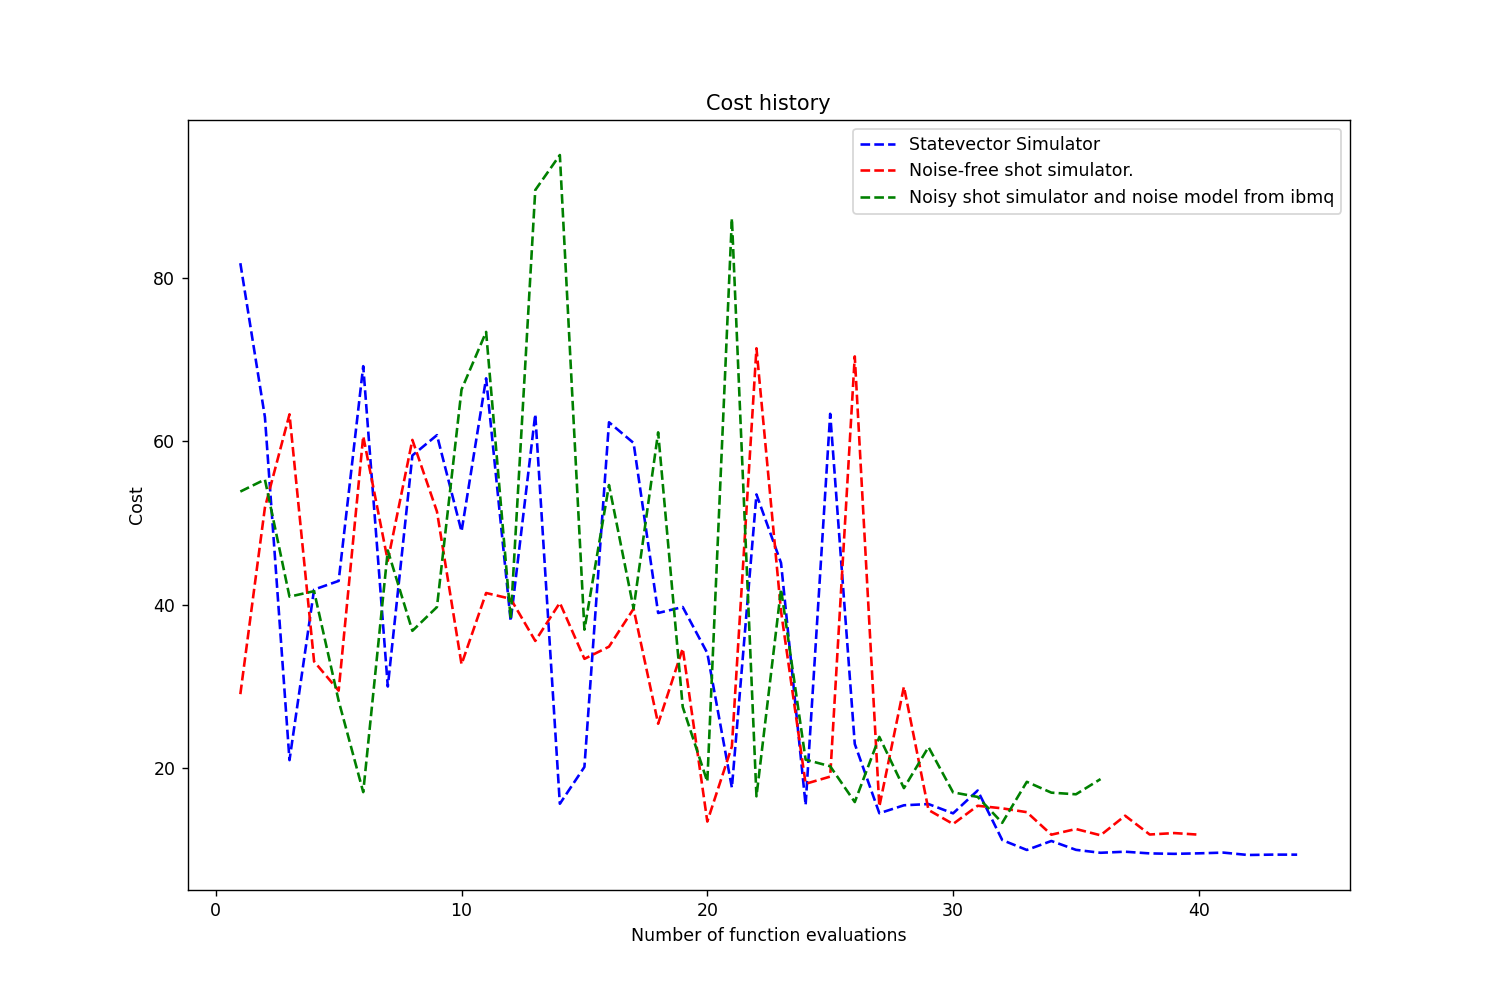

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

results_sv.plot_cost(ax=ax,label='Statevector Simulator')
results_shot.plot_cost(ax=ax,color='red', label='Noise-free shot simulator.')
results_noisy_shot.plot_cost(ax=ax,color='green', label='Noisy shot simulator and noise model from ibmq')

The addition of a noise model represents a step closer to the conditions experienced on actual quantum hardware, as opposed to the idealized conditions of a simulator without noise. Noise in quantum computing can come from various sources, such as errors in quantum gate operations, qubit measurement errors, and decoherence. A noise model attempts to mimic these imperfections and can provide a more realistic assessment of how a quantum algorithm might perform on a real quantum computer.

## Last comments:

<div class="alert alert-block alert-success">
    
- In terms of originality, this project stands by applying quantum computing principles to the **Task Scheduling Problem (TSP)**. We used the *Quantum Approximate Optimization Algorithm (QAOA)* within the OpenQAOA framework, and the subsequent tuning to account for realistic noise models, which address complex problems through quantum algorithms. The team's exploration of various parameters and optimizers to enhance the QAOA circuit's performance demonstrates a commendable attempt at tackling quantum optimization in a novel context.

    
- Regarding usability and knowledge, the project exemplifies a decent degree of functionality in its design, ensuring that the principles used are grounded in quantum theory and can be take as reference by others interested in compare Qiskit simulators with different methods.
</div>

# Acknowledgments

🎉🎉🎉 

Special thanks to Entropica Labs for helping us create this challenge and being able to use their SDK, OpenQAOA. If you want to know more about OpenQAOA or ask them questions directly, check out their [discord channel](discord.gg/ana76wkKBd).

🎉🎉🎉 